In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os

In [2]:
import pandas as pd
import os

def load_and_process_csv(path, term_in_file='PMTrans'):
    # List to hold individual DataFrames with hierarchical indices
    dfs = []
    is_PMNN = term_in_file in ['h4q', 'tbqq']  # Check for PMNN cases
    is_PMNN_test = term_in_file in ['h4q_test', 'tbqq_test']  # Check for test variants

    # List all CSV files in the given directory
    for filename in os.listdir(path):
        # Only process files ending with '.csv' and matching the term_in_file conditions
        if filename.endswith('.csv') and term_in_file in filename:
            # Ensure that '_test' is not in filename when term_in_file is 'h4q' or 'tbqq'
            if (is_PMNN and '_test' not in filename) or is_PMNN_test or (term_in_file not in ['h4q', 'tbqq']):
                # Split the filename by '_'
                temp_filename = filename
                if 'h4q_test' in filename:
                    temp_filename = filename.replace('h4q_test', 'h4q-test')
                elif 'tbqq_test' in filename:
                    temp_filename = filename.replace('tbqq_test', 'tbqq-test')

                parts = temp_filename.split('_')

                if len(parts) == 9:
                    start_dim = 4
                else:
                    start_dim = 3

                if is_PMNN or is_PMNN_test:
                    start_dim += 1

                # Extract particle and jet information
                particle_geom = parts[start_dim]
                particle_dim = int(parts[start_dim + 1])
                if 'x' in particle_geom:
                    particle_dim *= 2

                if not (is_PMNN or is_PMNN_test):
                    jet_geom = parts[start_dim + 2]
                    jet_dim = int(parts[start_dim + 3])
                    if 'x' in jet_geom:
                        jet_dim *= 2

                # Load the CSV into a DataFrame
                df = pd.read_csv(os.path.join(path, filename))

                # Create a MultiIndex for this DataFrame
                if is_PMNN or is_PMNN_test:
                    index_tuples = [(particle_geom, particle_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])
                else:
                    index_tuples = [(particle_geom, particle_dim, jet_geom, jet_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

                # Assign the MultiIndex to the DataFrame
                df.index = index
                df['name'] = filename

                # Append the DataFrame to the list
                dfs.append(df)
    
    # Concatenate all DataFrames into one, maintaining the hierarchical index
    combined_df = pd.concat(dfs)
    
    return combined_df


In [44]:
import matplotlib.pyplot as plt

def correct_string_to_latex(s):
    # Split the string by underscores to handle multiple terms
    terms = s.split('x')
    temp_str = ''
    # Transform each term into LaTeX format with superscripts
    latex_terms = []
    
    i = 0
    while i < len(terms):
        
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    
    # Join terms with the LaTeX product symbol if there are multiple terms
    latex_string = ' \\times '.join(latex_terms)
    
    return f"${temp_str}$"

def plot_highest_accuracies(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            filter_values=None, 
                            acc_range = None,
                            title = None,
                            PMNN = False):
    # Identify the columns that will remain constant
    leg_title = ''
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)
    
    
    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            if val == 'match' and col in ['particle_geom', 'jet_geom']:
                # Select rows where 'particle_geom' and 'jet_geom' are the same
                df = df[df.index.get_level_values('particle_geom') == df.index.get_level_values('jet_geom')]
            else:
                # Regular filtering based on the provided value
                df = df[df.index.get_level_values(col) == val]



    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    
    # Plot each group
    plt.figure(figsize=(10, 8),facecolor='white')
    for name, group in grouped:
        if PMNN: 
            name = correct_string_to_latex(name)
            leg_title = 'Particle-Level Geom.'
        else:
            if 'particle_geom' in filter_values:
                name = correct_string_to_latex(name[-1]) 
                leg_title = 'Jet-Level Geom.'
            else:
                name = correct_string_to_latex(name[0]) 
                leg_title = 'Particle-Level Geom.'
                
        # Find the maximum accuracy for each unique value in the variable_to_vary column
        if PMNN:
            max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
            max_values = max_values.drop(columns=['name'])
            max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.nlargest(2).mean())
            
            

        else:
            max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
            
        # Plot the data
        plt.plot(max_accuracy.index, 100*max_accuracy.values, marker='o', label=f"{name}")
    if variable_to_vary == 'particle_dim':
        y_label = 'Particle-Level Dim'
    else:
        y_label = 'Jet-Level Dim'
        
    plt.xlabel(y_label)
    plt.ylabel('Accuracy (%)')
    if title is not None:
        plt.title(f'{title} Accuracy With Respect to {leg_title}')
    else:
        plt.title(f'Accuracies with respect to {leg_title}')
        
    plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
    plt.grid(True)
    plt.tight_layout()
    if PMNN:
        plt.xscale('log', base=2)
    if acc_range is not None:
        plt.ylim(*acc_range)
    plt.show()


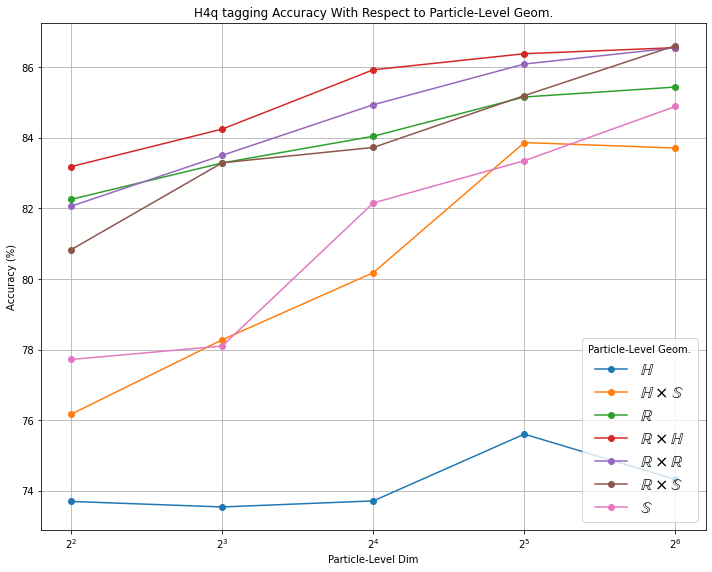

In [65]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', variable_to_vary='particle_dim',PMNN = True)

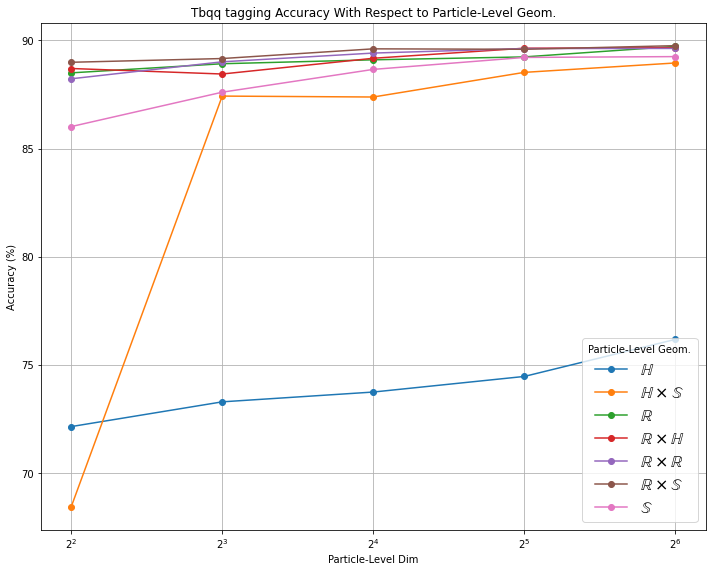

In [66]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'tbqq')
plot_highest_accuracies(combined_df,title = 'Tbqq tagging', variable_to_vary='particle_dim',PMNN = True)

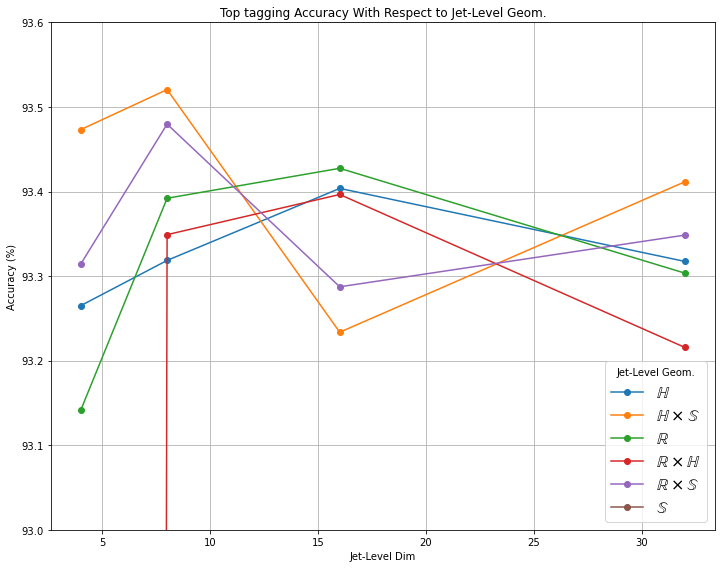

In [664]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,metric_column = 'test_acc',title = 'Top tagging', variable_to_vary='jet_dim', filter_values=filter_values, acc_range = [93,93.6])

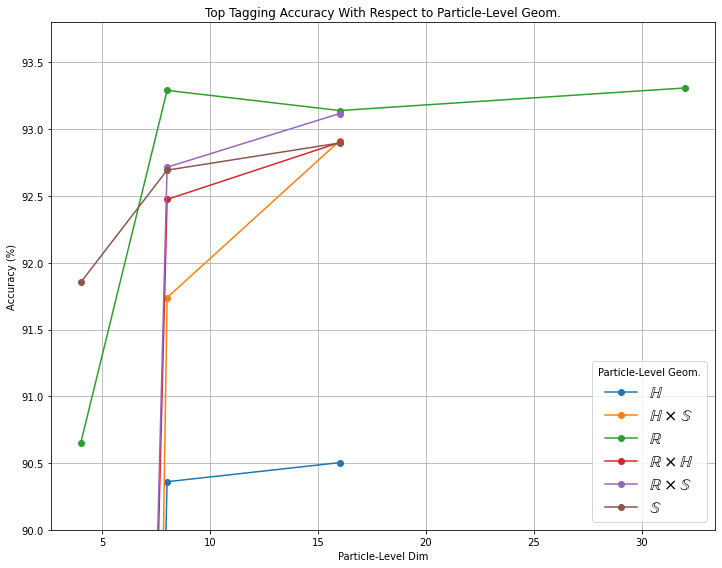

In [567]:
path = 'TopLandscape_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df,title = 'Top Tagging', variable_to_vary='particle_dim',acc_range = [90,93.8], filter_values=filter_values)

In [69]:
print(combined_df)

                            epoch       acc      loss  auc  test_acc  \
particle_geom particle_dim                                             
RxH           16              0.0  0.774346  0.507724  NaN       NaN   
              16              1.0  0.854766  0.392049  NaN       NaN   
              16              2.0  0.876172  0.343479  NaN       NaN   
              16              3.0  0.876445  0.328016  NaN       NaN   
              16              4.0  0.880566  0.321372  NaN       NaN   
...                           ...       ...       ...  ...       ...   
RxS           64              7.0  0.499775  0.693147  NaN       NaN   
              64              8.0  0.500215  0.693147  NaN       NaN   
              64              9.0  0.499502  0.693147  NaN       NaN   
              64              NaN       NaN       NaN  NaN       0.0   
              64              NaN       NaN       NaN  NaN       1.0   

                            test_auc  test_loss  \
particle_geo

In [68]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 16
}
plot_highest_accuracies(combined_df,title = 'JetClass', variable_to_vary='jet_dim',filter_values=filter_values)

ValueError: invalid literal for int() with base 10: 'HxS'

In [571]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df, title = 'JetClass',variable_to_vary='particle_dim',filter_values=filter_values)

ValueError: invalid literal for int() with base 10: 'HxS'

In [572]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,title = 'JetClass', variable_to_vary='jet_dim',filter_values=filter_values,acc_range = [60,80])

ValueError: invalid literal for int() with base 10: 'HxS'

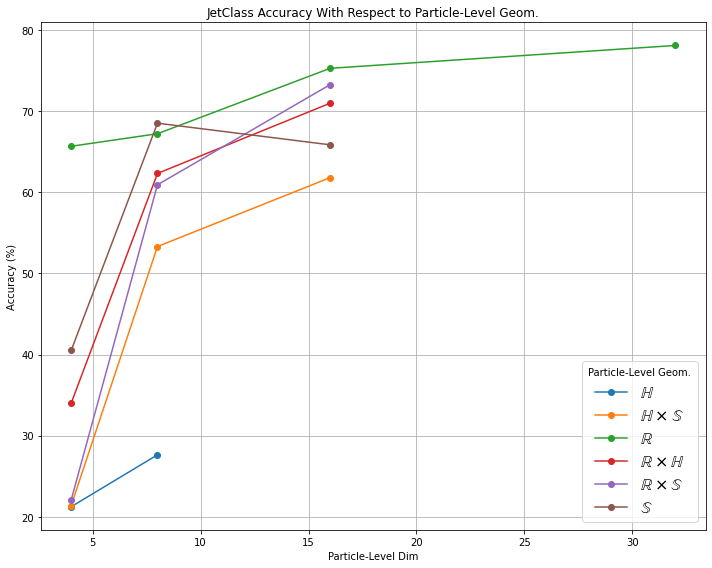

In [589]:
path = 'JetClass_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 32
}
plot_highest_accuracies(combined_df, title = 'JetClass',variable_to_vary='particle_dim',filter_values=filter_values)

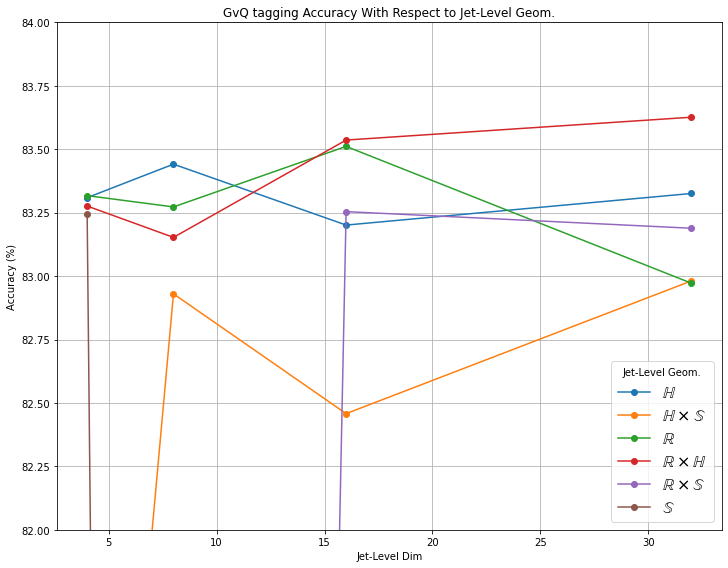

In [590]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}
plot_highest_accuracies(combined_df,metric_column = 'acc',title = 'GvQ tagging', variable_to_vary='jet_dim',filter_values=filter_values,acc_range=[82,84])

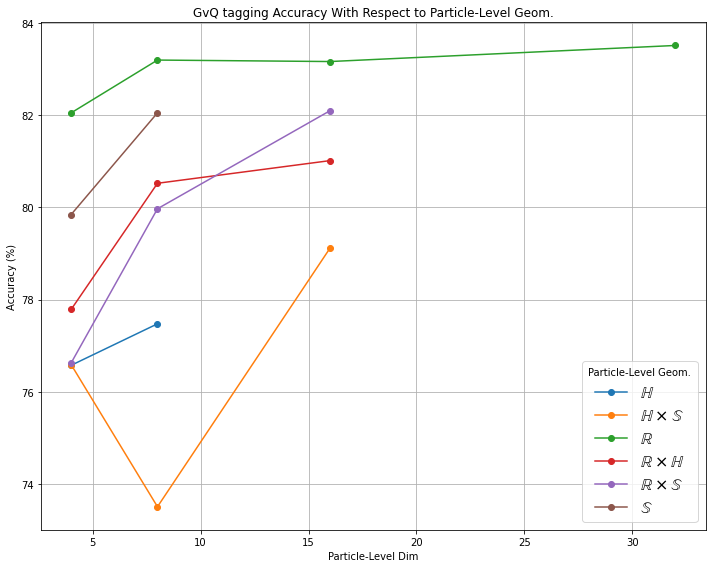

In [610]:
path = 'QuarkGluon_performance_summary'
combined_df = load_and_process_csv(path)
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
plot_highest_accuracies(combined_df,title = 'GvQ tagging', variable_to_vary='particle_dim', filter_values=filter_values)

In [470]:
# Function to calculate metrics for each class
def calculate_metrics(y_true, y_scores, target_tprs=[0.5, 0.7, 0.99]):
    unique_classes = np.unique(y_true)
    aucs = {}
    accuracies = {}
    rejections = {tpr: {} for tpr in target_tprs}
    fprs = {}
    tprs = {}

    for class_label in unique_classes:
        binary_y_true = (y_true == class_label).astype(int)
        y_score = y_scores[:, class_label]

        if len(np.unique(binary_y_true)) < 2:
            aucs[class_label] = None
            accuracies[class_label] = None
            for tpr in target_tprs:
                rejections[tpr][class_label] = None
            fprs[class_label] = None
            tprs[class_label] = None
            continue

        fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)
        auc = roc_auc_score(binary_y_true, y_score)
        accuracy = accuracy_score(binary_y_true, y_score >= 0.5)
        
        rejections_for_class = {}
        for tpr_value in target_tprs:
            if tpr_value in tpr:
                target_index = np.where(tpr >= tpr_value)[0][0]
                target_fpr = fpr[target_index]
                rejections_for_class[tpr_value] = 1 / target_fpr if target_fpr != 0 else np.inf
            else:
                rejections_for_class[tpr_value] = None
        
        aucs[class_label] = auc
        accuracies[class_label] = accuracy
        for tpr in target_tprs:
            rejections[tpr][class_label] = rejections_for_class[tpr]
        
        # Check if fpr and tpr are lists before converting them
        fprs[class_label] = fpr.tolist() if isinstance(fpr, (list, np.ndarray)) else []
        tprs[class_label] = tpr.tolist() if isinstance(tpr, (list, np.ndarray)) else []

    return aucs, accuracies, rejections, fprs, tprs


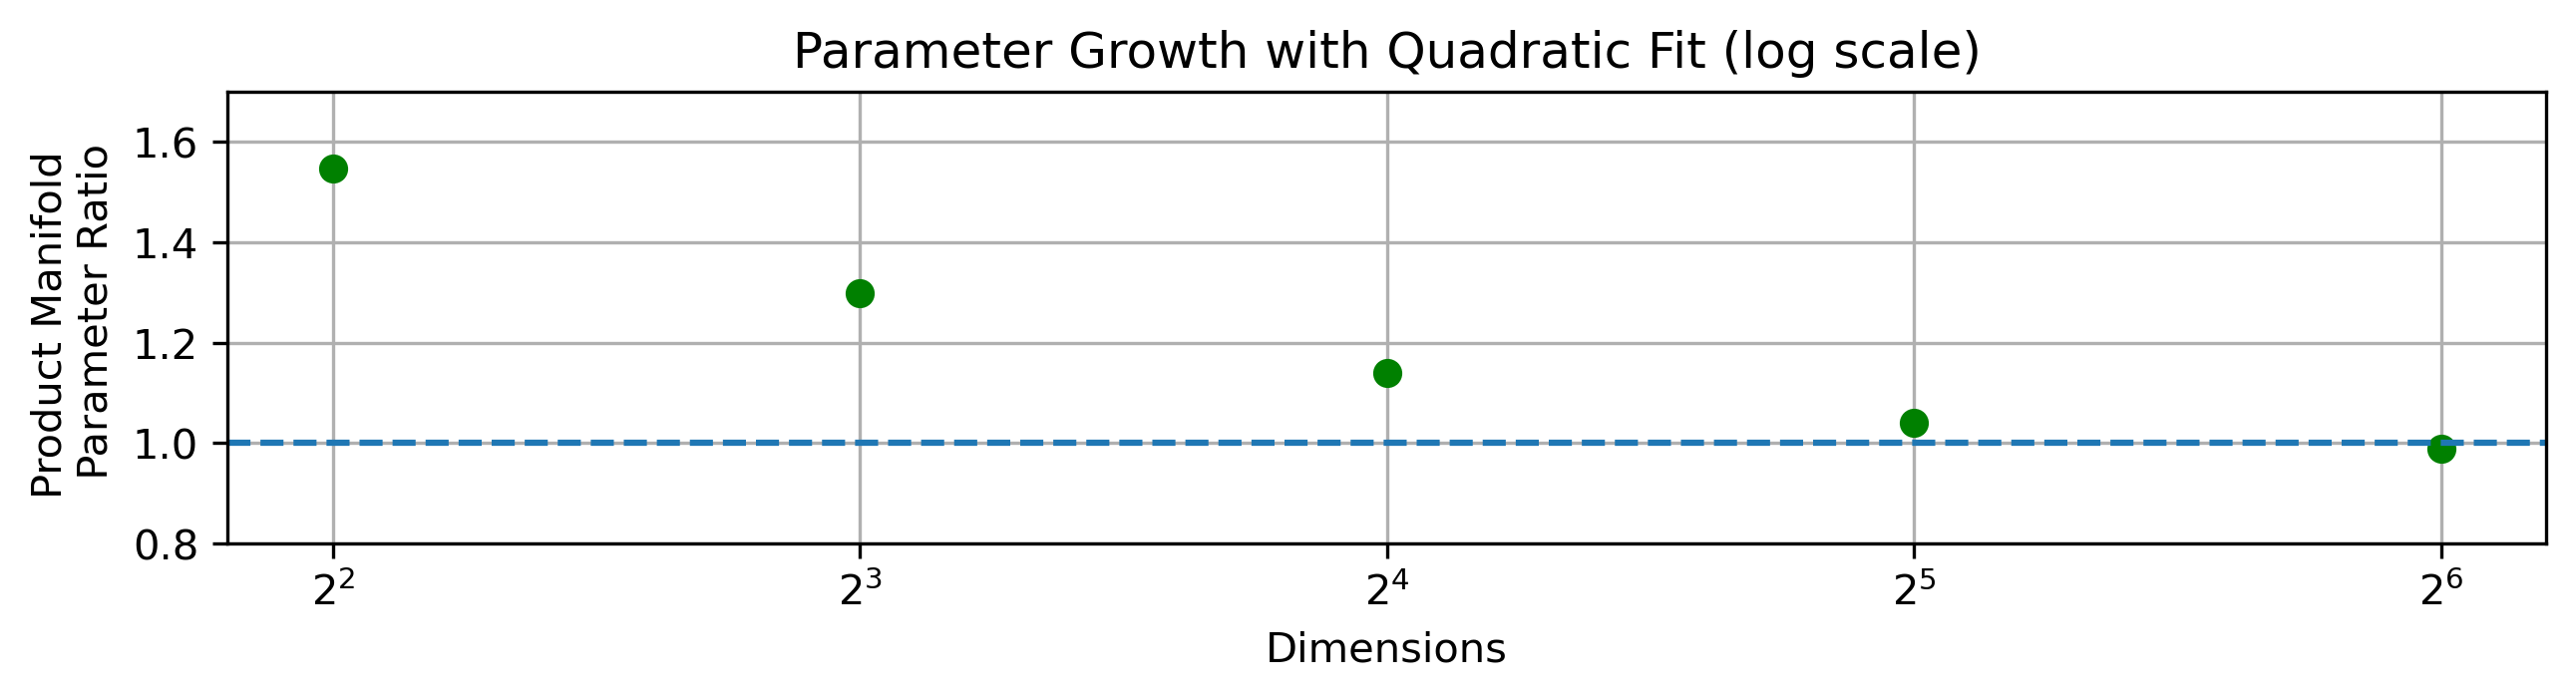

In [649]:
# total_dims = [4,8,16,32,64,128,256]
# prod_man_params = [243,357,705, 1810,5650,19860,74390]
# single_man_params = [157, 275,619, 1740, 5710,20550, 77900]

total_dims = [4,8,16,32,64]
prod_man_params = [243,357,705, 1810,5650]
single_man_params = [157, 275,619, 1740, 5710]


# Convert to log base 2 for the x-axis
log_total_dims = total_dims

# Fit quadratic models (2nd degree polynomial) for both data sets
prod_fit = np.polyfit(log_total_dims, prod_man_params, 2)
single_fit = np.polyfit(log_total_dims, single_man_params, 2)

# Generate x values for the plot up to dimension 512
x_vals = np.array([4, 8, 16, 32, 64, 128, 256, 512])

# Calculate the fitted quadratic curves
prod_quad_fit = np.polyval(prod_fit, x_vals)
single_quad_fit = np.polyval(single_fit, x_vals)

# Plotting the data and the fits
plt.figure(figsize=(10, 2),dpi = 300)
# plt.plot(log_total_dims, prod_man_params, 'o', label='Prod Manifold Params', color='blue')
plt.plot(log_total_dims, np.array(prod_man_params)/np.array(single_man_params), 'o', label='Single Manifold Params', color='green')

# # Plot the quadratic fits
# plt.plot(x_vals, prod_quad_fit, '--', label='Prod Manifold Fit', color='blue')
# plt.plot(x_vals, single_quad_fit, '--', label='Single Manifold Fit', color='green')

# Set log scale for y-axis
# plt.yscale('log',base = 10)
plt.xscale('log',base = 2)
plt.axhline(1,linestyle='--')
plt.ylim(0.8,1.7)
# plt.xlim()

# Set labels and title
plt.xlabel('Dimensions')
plt.ylabel('Product Manifold \n Parameter Ratio')
plt.title('Parameter Growth with Quadratic Fit (log scale)')

# Add legend
# plt.legend()

# Show plot
plt.grid(True)
plt.show()